In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from copy import deepcopy
import sklearn
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

Using TensorFlow backend.


In [2]:
df =pd.read_csv("Final-Dataset.csv")
# df =pd.read_csv("Model.csv")

column = df.columns
print(column)

Index(['Model', 'Network Type', 'GPRS', 'Year', 'Month', 'Height', 'Breadth',
       'Width', 'Weight', 'Sim', 'Screen', 'Screen Size', 'Resolution_X',
       'Resolution_Y', 'OS', 'Chipset', 'Cores', 'GPU', 'External Memory',
       'Hard Disk', 'Main Memory', 'GPS', 'USB Type', 'Battery Size', 'NFC',
       'Wifi', 'Radio', 'Fingerprint', 'Accelerometer', 'Gyroscope',
       'Proximity'],
      dtype='object')


In [3]:
temp = df.values
drop = []
for i in range(len(df)):
    for j in range(len(temp[i])):
        if temp[i][j] == '-':
            drop.append(i)
            break

df.drop(df.index[drop], inplace=True)

In [4]:
categorical = ['Screen','OS','Chipset','GPU','Wifi']

# print((df[ df['Model'] == 'Honor' ].shape))

Class = df['Model']
Data = df.drop(df.columns[[0]], axis=1)
train = Data
Label = Class

In [5]:
columns = Data.columns
for i in columns:
    if i not in categorical:
        Data[i] = pd.to_numeric(Data[i])

In [6]:
labels = []
for i in range(len(categorical)):
    labels.append(preprocessing.LabelEncoder())
    labels[i].fit(Data[categorical[i]])
    Data[categorical[i]] = labels[i].transform(Data[categorical[i]]) 

In [7]:
Data = Data.reset_index(drop=True)
Class = Class.reset_index(drop=True)
Data.head()
# temp = Data.values
# for i in range()

,Network Type,GPRS,Year,Month,Height,Breadth,Width,Weight,Sim,Screen,...,GPS,USB Type,Battery Size,NFC,Wifi,Radio,Fingerprint,Accelerometer,Gyroscope,Proximity
0,35,1,2009,6,115.9,56.0,11.9,116.7,1,6,...,1,2.0,1500,0,2,0,0,1,0,0
1,35,1,2010,1,129.0,60.4,16.4,156.0,1,6,...,2,2.0,1540,0,2,0,1,1,0,0
2,35,1,2010,3,242.8,189.7,13.4,730.0,1,1,...,2,2.0,6600,0,1,0,0,1,0,0
3,0,0,2010,3,242.8,189.7,13.4,680.0,0,1,...,0,2.0,6600,0,1,0,0,1,0,0
4,35,1,2010,3,108.0,53.0,15.3,133.0,1,6,...,2,2.0,1400,0,2,0,0,1,0,1


# Heat Map

In [8]:
temp = preprocessing.LabelEncoder()
temp.fit(Class)
Class = temp.transform(Class) 
df_class = pd.DataFrame(Class)
Data['Model'] = df_class[0]
Data.head()

,Network Type,GPRS,Year,Month,Height,Breadth,Width,Weight,Sim,Screen,...,USB Type,Battery Size,NFC,Wifi,Radio,Fingerprint,Accelerometer,Gyroscope,Proximity,Model
0,35,1,2009,6,115.9,56.0,11.9,116.7,1,6,...,2.0,1500,0,2,0,0,1,0,0,3
1,35,1,2010,1,129.0,60.4,16.4,156.0,1,6,...,2.0,1540,0,2,0,1,1,0,0,2
2,35,1,2010,3,242.8,189.7,13.4,730.0,1,1,...,2.0,6600,0,1,0,0,1,0,0,0
3,0,0,2010,3,242.8,189.7,13.4,680.0,0,1,...,2.0,6600,0,1,0,0,1,0,0,0
4,35,1,2010,3,108.0,53.0,15.3,133.0,1,6,...,2.0,1400,0,2,0,0,1,0,1,2


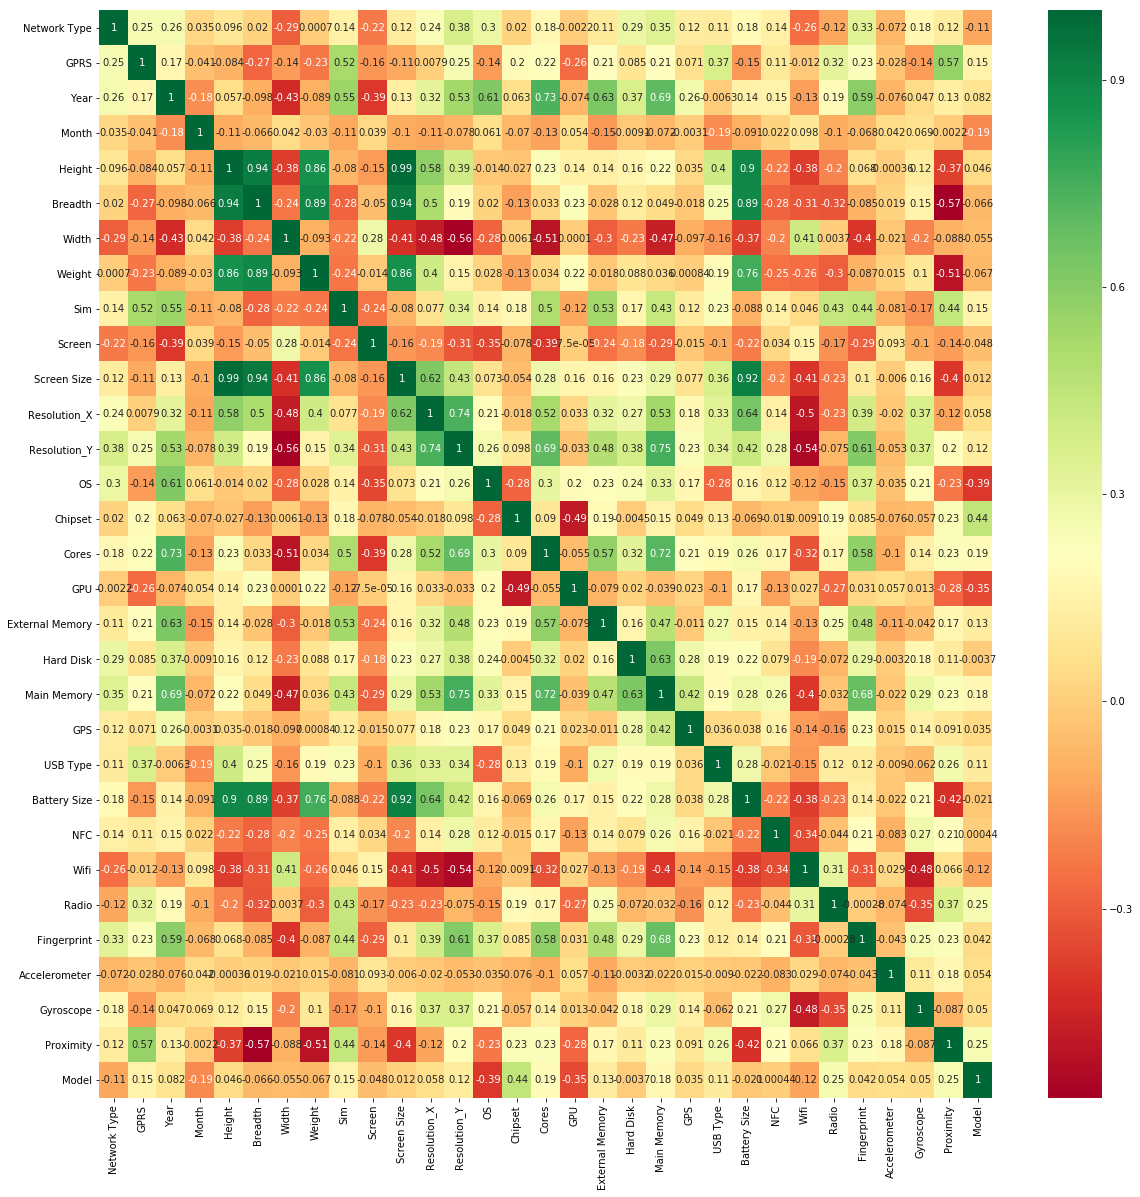

In [9]:
corrmat = Data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(Data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Select K Best

In [10]:
X = Data.iloc[:,0:30]
y = Data.iloc[:,-1]

In [11]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']

print(featureScores.nlargest(13,'Score'))

              Specs         Score
0      Network Type  67724.232563
20              GPS  41610.618217
22     Battery Size  24379.175598
17  External Memory  12047.586788
12     Resolution_Y  10932.339071
14          Chipset   8143.966605
18        Hard Disk   4562.315021
7            Weight   2910.785838
11     Resolution_X   2909.539659
13               OS   2863.704784
16              GPU   1650.390380
5           Breadth    451.619909
4            Height    189.503108


# Extra Tree Classifier

/home/chikki/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


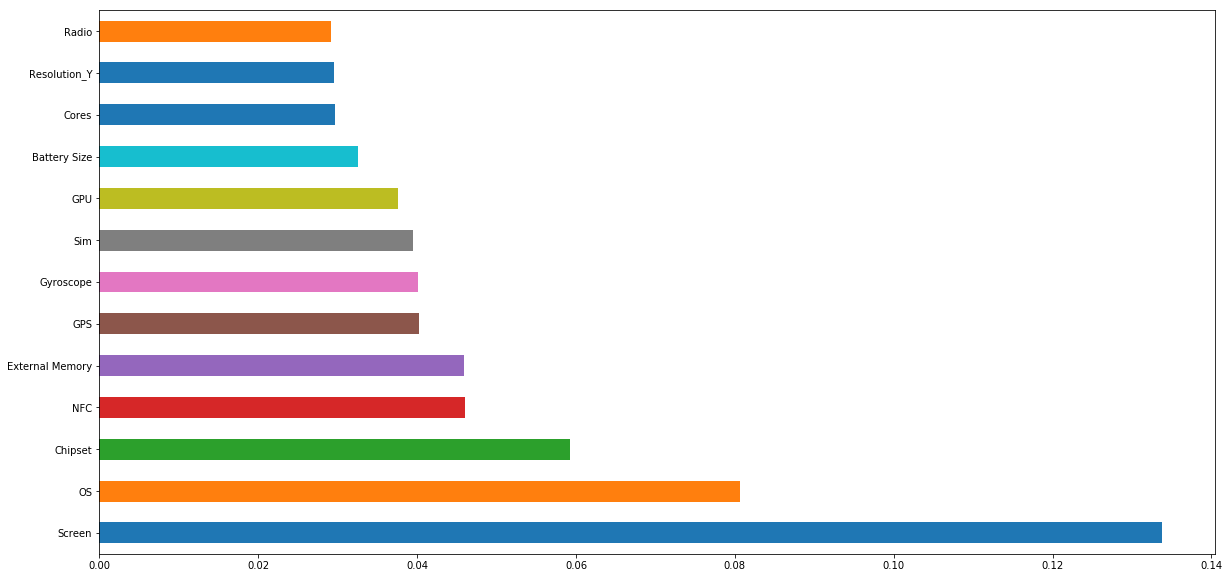

In [12]:
model = ExtraTreesClassifier()
model.fit(X,y)

plt.figure(figsize=(20,10))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(13).plot(kind='barh')

plt.show()

# Random Tree Classifier

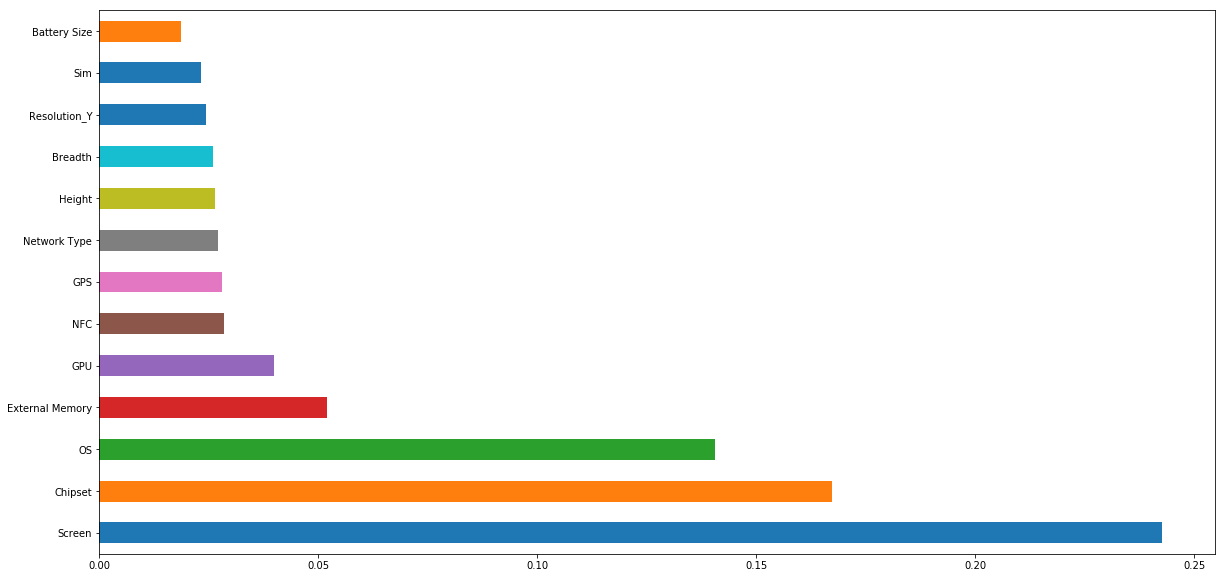

In [13]:
model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0)
model.fit(X,y)

plt.figure(figsize=(20,10))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(13).plot(kind='barh')

plt.show()

# Prediction Using Random Forest Classifier

In [14]:
clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0)
clf.fit(train, Label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [15]:
l = clf.feature_importances_
sorted_index = l.argsort()[::-1]
Sel_col = train.columns[sorted_index]
Imp = l[sorted_index]

In [16]:
Titles = []
ans = 0
for i in range(len(Imp)):
    if(ans < 0.90):
        ans += Imp[i]
        Titles.append(Sel_col[i])
    else:
        break
print(Titles)

['Screen', 'Chipset', 'OS', 'External Memory', 'GPU', 'NFC', 'GPS', 'Network Type', 'Height', 'Breadth', 'Resolution_Y', 'Sim', 'Battery Size', 'Screen Size', 'Main Memory', 'Weight', 'Width']


In [17]:
X = train[Titles]
train_X = X[:500]
test_X = X[500:]
train_Y = Label[:500]
test_Y = Label[500:]

clf.fit(train_X, train_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [18]:
test = test_X.values
real = test_Y.values

pred = []
for i in range(len(test)):
    pred.append(clf.predict([test[i]])[0])

print(" Accuracy = " ,accuracy_score(real, pred))
temp = precision_recall_fscore_support(real, pred, average='macro')
print(" Precision = ", temp[0])
print(" Recall = ", temp[1])
print(" F-Score = ", temp[2])

# features = len(Titles)

 Accuracy =  0.591928251121
 Precision =  0.582157953761
 Recall =  0.570973251517
 F-Score =  0.521831116287


# Prediction Using Extra Tree Classifier

In [19]:
etc = sklearn.tree.ExtraTreeClassifier()
etc.fit(train_X, train_Y)

ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')

In [20]:
test = test_X.values
real = test_Y.values

pred = []
for i in range(len(test)):
    pred.append(etc.predict([test[i]])[0])

print(" Accuracy = " ,accuracy_score(real, pred))
temp = precision_recall_fscore_support(real, pred, average='macro')
print(" Precision = ", temp[0])
print(" Recall = ", temp[1])
print(" F-Score = ", temp[2])

 Accuracy =  0.632286995516
 Precision =  0.608012323638
 Recall =  0.61757352428
 F-Score =  0.608880129373


# SVM

In [21]:
from sklearn import svm

model_svm = svm.SVC()
model_svm.fit(train_X, train_Y)  

/home/chikki/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [22]:
test = test_X.values
real = test_Y.values

pred = []
for i in range(len(test)):
    pred.append(model_svm.predict([test[i]])[0])

print(" Accuracy = " ,accuracy_score(real, pred))
temp = precision_recall_fscore_support(real, pred, average='macro')
print(" Precision = ", temp[0])
print(" Recall = ", temp[1])
print(" F-Score = ", temp[2])

 Accuracy =  0.318385650224
 Precision =  0.0530642750374
 Recall =  0.166666666667
 F-Score =  0.0804988662132


/home/chikki/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(train_X, train_Y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [24]:
test = test_X.values
real = test_Y.values

pred = []
for i in range(len(test)):
    pred.append(neigh.predict([test[i]])[0])

print(" Accuracy = " ,accuracy_score(real, pred))
temp = precision_recall_fscore_support(real, pred, average='macro')
print(" Precision = ", temp[0])
print(" Recall = ", temp[1])
print(" F-Score = ", temp[2])

 Accuracy =  0.363228699552
 Precision =  0.418626424929
 Recall =  0.311797183487
 F-Score =  0.320520404343


# Naive Bayes

In [25]:
from sklearn.naive_bayes import GaussianNB
naive = GaussianNB()
naive.fit(train_X, train_Y) 

GaussianNB(priors=None, var_smoothing=1e-09)

In [26]:
test = test_X.values
real = test_Y.values

pred = []
for i in range(len(test)):
    pred.append(naive.predict([test[i]])[0])

print(" Accuracy = " ,accuracy_score(real, pred))
temp = precision_recall_fscore_support(real, pred, average='macro')
print(" Precision = ", temp[0])
print(" Recall = ", temp[1])
print(" F-Score = ", temp[2])

 Accuracy =  0.466367713004
 Precision =  0.487023135163
 Recall =  0.475042915388
 F-Score =  0.440071568686


# RNN

In [27]:
lb = preprocessing.LabelEncoder()
lb.fit(Class)
Class = lb.transform(Class) 
X['Model'] = Class
X.head()

/home/chikki/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Screen,Chipset,OS,External Memory,GPU,NFC,GPS,Network Type,Height,Breadth,Resolution_Y,Sim,Battery Size,Screen Size,Main Memory,Weight,Width,Model
125,6,81,0,16.0,0,0,1,35,115.9,56.0,480,1,1500,3.2,0.125,116.7,11.9,3
138,6,88,50,32.0,1,0,2,35,129.0,60.4,640,1,1540,3.0,0.250,156.0,16.4,2
141,1,2,59,0.0,61,0,2,35,242.8,189.7,1024,1,6600,9.7,0.250,730.0,13.4,0
142,1,2,59,0.0,61,0,0,0,242.8,189.7,1024,0,6600,9.7,0.250,680.0,13.4,0
143,6,82,0,32.0,0,0,2,35,108.0,53.0,480,1,1400,3.1,0.250,133.0,15.3,2


In [28]:
mini = X.min()
rang = X.max()-X.min()
mini[-1] = 0
rang[-1] = 1
data = (X-mini)/rang
mini = mini[:-1]
rang = rang[:-1]

In [29]:
class rnn(object) :
    def __init__(self, layers , nodes , time_step , epochs = 100):
        self.layers = layers
        self.nodes = nodes
        self.time_step = time_step
        self.epochs = epochs
        self.history = None
        
    def data_process(self,  data):
        X,Y = [],[]
        for i in range(len(data)-self.time_step-1):
            X.append(data[i:(i + self.time_step),:])
            Y.append(data[(i+self.time_step),:])
        return np.array(X),np.array(Y)
        
    def fit_and_predict(self , data):
        X,y = self.data_process(data)
        X_train,X_test = X[:int(X.shape[0]*0.80) , :],X[int(X.shape[0]*0.80):, :]
        y_train,y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
        
        model = Sequential()
        model.add(LSTM(self.nodes, return_sequences=True,input_shape=(self.time_step, X_train.shape[-1])))
        
        for i in range(self.layers-2) :
            model.add(LSTM(self.nodes, return_sequences=True))
        model.add(LSTM(self.nodes))
        model.add(Dense(features , activation =  'relu'))
        model.compile(optimizer='adam',loss='mse')

        self.history = model.fit(X_train,y_train,epochs=self.epochs,validation_data=(X_test,y_test),shuffle=True, verbose = 0)
        Xt = model.predict(X_test)
        return y_test,Xt
        # print(y_test,Xt)
        # input data shape: (batch_size, timesteps, data_dim)

In [36]:
rnn1 = rnn(3, 30, 10, 100)
print(X['Model'].unique())
print("Enter Model for which you want to predict")
model = input()
data1 = X['Model'] == int(model)
data1 = X[data1]
data1 = data1.drop(columns='Model')
data1 = data1.as_matrix()
features = data1.shape[1]

[3 2 0 4 1 5]
Enter Model for which you want to predict
2


In [37]:
expected,predicted = rnn1.fit_and_predict(data1)

In [38]:
expected = pd.DataFrame(expected)
predicted = pd.DataFrame(predicted)

In [39]:
def Acc(X,Y):
    X = X.as_matrix()
    Y = Y.as_matrix()
    ans = 0
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if(abs(X[i][j] - Y[i][j]) <= 1):
                ans += 1
    return (ans*100)/(X.shape[0]*X.shape[1])

In [40]:
print(Acc(expected,predicted))

20.0


# Prediction

### Legends

    == Network Type
        GSM   5
        CDMA  2
        HSPA  7
        EVDO  3
        LTE   11
        UMTS  13
    
    == Categorical Data
        Screen OS Chipset GPU Wifi   

In [83]:
#test = ['Screen', 'Chipset', 'OS', 'External Memory', 'GPU', 'NFC', 'GPS', 'Network Type', 'Height', 'Breadth', 'Resolution_Y', 'Sim', 'Battery Size', 'Screen Size', 'Main Memory', 'Weight', 'Width']

test = ['Super AMOLED', 'Qualcomm MSM8255T', 'Android 2.3', 32, 'Adre0 205', 0, 2, 35, 122.4, 64.2, 800, 1, 1650, 4, 0.5, 119, 9.9]
real_class = ['Samsung']

test[0] = labels[0].transform([test[0]])[0]
test[1] = labels[2].transform([test[1]])[0]
test[2] = labels[1].transform([test[2]])[0]
test[4] = labels[3].transform([test[4]])[0]

print("Real Class :                     ",real_class[0])
print("Prediction Using Random Forest : ",clf.predict([test])[0])
print("Prediction Using Extra Tree :    ",clf.predict([test])[0])
print("Prediction Using SVM :           ",model_svm.predict([test])[0])
print("Prediction Using KNN (n=5) :     ",neigh.predict([test])[0])
print("Prediction Using Naive Bayes :   ",naive.predict([test])[0])


Real Class :                      Samsung
Prediction Using Random Forest :  Samsung
Prediction Using Extra Tree :     Samsung
Prediction Using SVM :            Samsung
Prediction Using KNN (n=5) :      Samsung
Prediction Using Naive Bayes :    Motorola
